In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import spearmanr

import utils as u
import processing as p
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

subjects_as_ints = [3509524, 5132496, 1066528, 5498603, 2638030, 2598705, 5383425, 1455390, 4018081, 9961348,
                            1449548, 8258170, 781756, 9106476, 8686948, 8530312, 3997827, 4314139, 1818471, 4426783,
                            8173033, 7749105, 5797046, 759667, 8000685, 6220552, 844359, 9618981, 1360686, 46343,
                            8692923]

## Loading and preparing the data

In [2]:
columns = ['id', 'timestamp', 'heartrate', 'heartrate_std', 'x_mean', 'x_std', 'y_mean', 'y_std', 'z_mean', 'z_std', 'magnitude', 'magnitude_std', 'label']
df = pd.DataFrame(columns=columns)
steps = pd.DataFrame(columns=['id', 'hour_bin', 'steps'])
sleep_df = pd.DataFrame(columns=['id', 'timestamp', 'label'])
for subject in subjects_as_ints:
    print('Reading data for subject ', subject, '...')

    path = u.get_file_path_motion(subject)
    #acc_frame = pd.read_csv(path, sep=" ", header=None, names=['timestamp', 'x', 'y', 'z'], dtype={'x': float, 'y': float, 'z': float})

    raw_acc_frame = pd.read_csv(path, sep=" ", header=None, names=['timestamp', 'x', 'y', 'z'])

    # Replace non-numeric values with NaN
    raw_acc_frame[['x', 'y', 'z']] = raw_acc_frame[['x', 'y', 'z']].apply(pd.to_numeric, errors='coerce')
    acc_frame = raw_acc_frame

    path = u.get_file_path_steps(subject)
    st_frame = pd.read_csv(path, sep=",", header=None, names=['timestamp', 'steps'])

    path = u.get_file_path_labels(subject)
    labels = pd.read_csv(path, sep=" ", header=None, names=['timestamp', 'label'])

    path = u.get_file_path_hr(subject)
    hr_frame = pd.read_csv(path, sep=",", header=None, names=['timestamp', 'heartrate'])

    # process steps
    st_frame = st_frame[st_frame['timestamp']<=0]
    st_frame_bins = p.process_steps(st_frame)
    st_frame_bins['id'] = str(subject)
    steps = pd.concat([steps, st_frame_bins])

    # process heart rate
    # hr_frame = hr_frame[hr_frame['timestamp']>=0]
    hr_frame_bins = p.process_heart_rate(hr_frame)

    # process motion
    # acc_frame = acc_frame[acc_frame['timestamp']>=0]
    acc_frame_bins = p.process_motion(acc_frame)

    # join heart rate with acceleration
    data = pd.merge(hr_frame_bins, acc_frame_bins, on='timestamp')
    # join the resulting dataframe with psg labels
    data1 = pd.merge(data, labels, on='timestamp')
    # data1 = pd.merge(data, labels, on='timestamp', how='left')
    # data1['label'] = data1['label'].fillna(method='ffill')

    labels['id'] = str(subject)
    sleep_df = pd.concat([sleep_df, labels])

    # add column 'id' to the resulting dataframe and choose only relevant columns
    data1['id'] = str(subject)
    data1 = data1[columns]

    # add this subjects data to the desired dataframe
    df = pd.concat([df, data1])
    print('Finished.')

Reading data for subject  3509524 ...
Finished.
Reading data for subject  5132496 ...
Finished.
Reading data for subject  1066528 ...
Finished.
Reading data for subject  5498603 ...
Finished.
Reading data for subject  2638030 ...
Finished.
Reading data for subject  2598705 ...
Finished.
Reading data for subject  5383425 ...
Finished.
Reading data for subject  1455390 ...
Finished.
Reading data for subject  4018081 ...
Finished.
Reading data for subject  9961348 ...
Finished.
Reading data for subject  1449548 ...
Finished.
Reading data for subject  8258170 ...
Finished.
Reading data for subject  781756 ...
Finished.
Reading data for subject  9106476 ...
Finished.
Reading data for subject  8686948 ...
Finished.
Reading data for subject  8530312 ...
Finished.
Reading data for subject  3997827 ...
Finished.
Reading data for subject  4314139 ...
Finished.
Reading data for subject  1818471 ...
Finished.
Reading data for subject  4426783 ...
Finished.
Reading data for subject  8173033 ...
Fin

In [3]:
df.describe()

,timestamp,heartrate,heartrate_std,x_mean,x_std,y_mean,y_std,z_mean,z_std,magnitude,magnitude_std
count,25924.000000,25924.000000,25913.000000,25924.000000,25924.000000,25924.000000,25924.000000,25924.000000,25924.000000,25924.000000,25924.000000
mean,13564.157923,64.343395,1.480288,-0.124296,0.011654,-0.088352,0.017858,-0.458667,0.016522,0.998113,0.005255
std,8315.157028,10.079715,1.897844,0.354821,0.047334,0.468522,0.066499,0.636524,0.070732,0.004492,0.016766
min,0.000000,41.166667,0.000000,-0.982602,0.000309,-0.999566,0.000452,-1.002029,0.000680,0.984703,0.000566
25%,6390.000000,57.000000,0.516398,-0.384310,0.001335,-0.434530,0.001386,-0.899284,0.001472,0.994852,0.001347
50%,12960.000000,64.000000,0.923548,-0.210387,0.001814,-0.071555,0.002246,-0.796098,0.001978,0.998101,0.001651
75%,20550.000000,70.500000,1.760682,0.095475,0.002761,0.215631,0.003541,-0.125347,0.002937,1.001333,0.002296
max,29670.000000,128.571429,30.237394,0.912211,0.720013,0.994768,0.820896,1.006896,0.943914,1.092541,0.318761


In [4]:
df.isnull().sum()

id                0
timestamp         0
heartrate         0
heartrate_std    11
x_mean            0
x_std             0
y_mean            0
y_std             0
z_mean            0
z_std             0
magnitude         0
magnitude_std     0
label             0
dtype: int64

In [5]:
df.dropna(inplace=True)

In [6]:
df.shape

(25913, 13)

In [7]:
df['label'].value_counts()

 2    12483
 5     5542
 3     3189
 0     2166
 1     1761
-1      416
 4      356
Name: label, dtype: int64

In [8]:
df = df[(df['label'] == 0) | (df['label'] == 1) | (df['label'] == 2) | (df['label'] == 3) | (df['label'] == 5)]

In [9]:
df['label'].value_counts()

2    12483
5     5542
3     3189
0     2166
1     1761
Name: label, dtype: int64

In [10]:
df.shape

(25141, 13)

In [11]:
def apply_wake_label(df):
    if df['label'] == 0:
        return 1
    else:
        return 0

df['wake'] = df.apply(apply_wake_label, axis=1)

In [12]:
df['wake'].value_counts()

0    22975
1     2166
Name: wake, dtype: int64

In [13]:
sleep_df.shape

(27211, 3)

In [14]:
steps_counts = []
sleep_counts = []
deep_sleep_counts = []
deep_percentages = []
wake_up_counts = []

for subject in subjects_as_ints:
    steps_subset = steps[steps['id'] == str(subject)]
    steps_count = p.steps_count(steps_subset, -2)
    steps_counts.append(steps_count)

    sleep_subset = sleep_df[sleep_df['id'] == str(subject)]
    sleep_count = p.measure_sleep(sleep_subset)
    sleep_count = sleep_count * 30 / 3600
    sleep_counts.append(sleep_count)
    if sleep_count < 4:
        print (subject)

    deep_sleep_count = p.measure_deep_sleep(sleep_subset)
    deep_sleep_count = deep_sleep_count * 30 / 3600
    deep_sleep_counts.append(deep_sleep_count)

    deep_percentage = (deep_sleep_count / sleep_count * 100) if sleep_count != 0 else 0
    deep_percentages.append(deep_percentage)

    wake_up_count = p.count_awakenings(sleep_subset)
    wake_up_counts.append(wake_up_count)

3509524
5132496
4018081
759667
46343


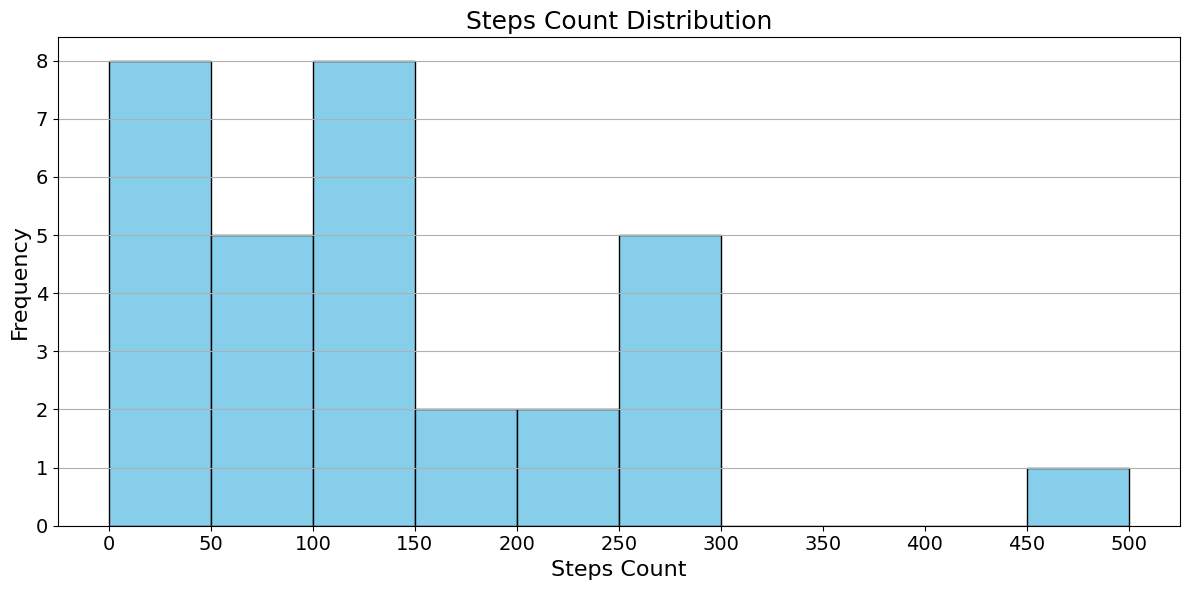

In [15]:
# define bins
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
# bins = [0, 100, 200, 300, 400, 500]
bins = u.generate_bins(np.floor(min(steps_counts)), np.ceil(max(steps_counts)), 50)

# plot
plt.figure(figsize=(12, 6))
plt.hist(steps_counts, bins=bins, edgecolor="k", color='skyblue')
plt.title('Steps Count Distribution', fontsize=18)
plt.xlabel('Steps Count', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(bins, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

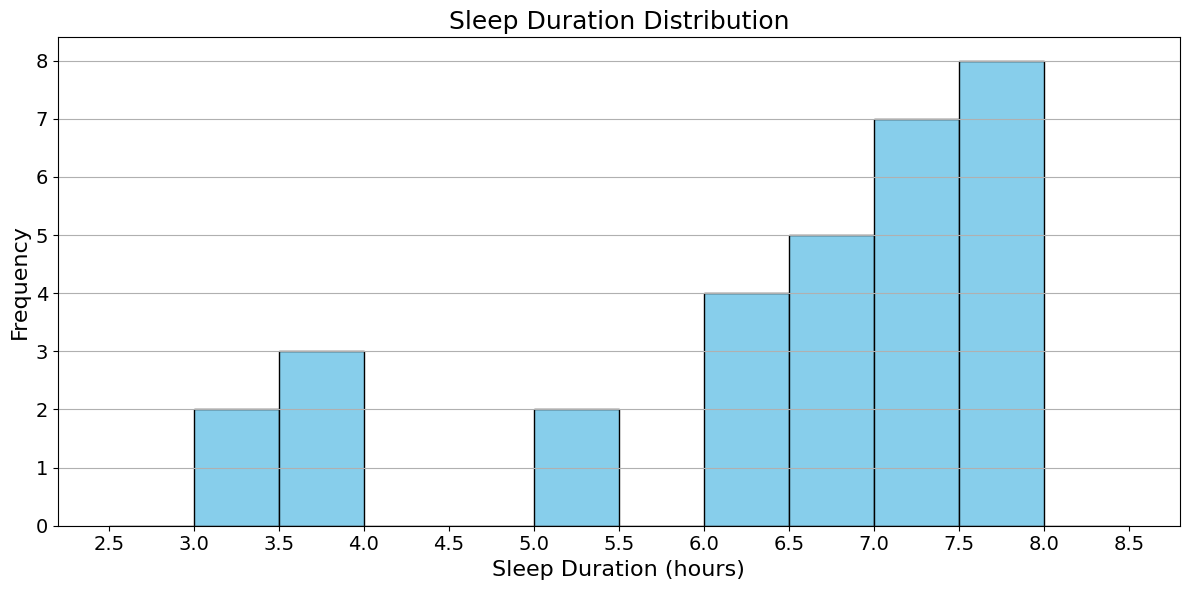

In [16]:
# define bins
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
bins = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0]

bins = u.generate_bins(np.floor(min(sleep_counts)), np.ceil(max(sleep_counts)), 0.5)

# bins = [0, 100, 200, 300, 400, 500]

# plot
plt.figure(figsize=(12, 6))
plt.hist(sleep_counts, bins=bins, edgecolor="k", color='skyblue')
plt.title('Sleep Duration Distribution', fontsize=18)
plt.xlabel('Sleep Duration (hours)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(bins, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [18]:
steps_counts = []
sleep_counts = []
deep_sleep_counts = []
deep_percentages = []
wake_up_counts = []

for subject in subjects_as_ints:
    steps_subset = steps[steps['id'] == str(subject)]
    steps_count = p.steps_count(steps_subset, -2)

    sleep_subset = sleep_df[sleep_df['id'] == str(subject)]
    sleep_count = p.measure_sleep(sleep_subset)
    sleep_count = sleep_count * 30 / 3600
    if sleep_count > 4:
        steps_counts.append(steps_count)
        sleep_counts.append(sleep_count)

        deep_sleep_count = p.measure_deep_sleep(sleep_subset)
        deep_sleep_count = deep_sleep_count * 30 / 3600
        deep_sleep_counts.append(deep_sleep_count)

        deep_percentage = (deep_sleep_count / sleep_count * 100) if sleep_count != 0 else 0
        deep_percentages.append(deep_percentage)

        wake_up_count = p.count_awakenings(sleep_subset)
        wake_up_counts.append(wake_up_count)
    else:
        print(subject)

3509524
5132496
4018081
759667
46343


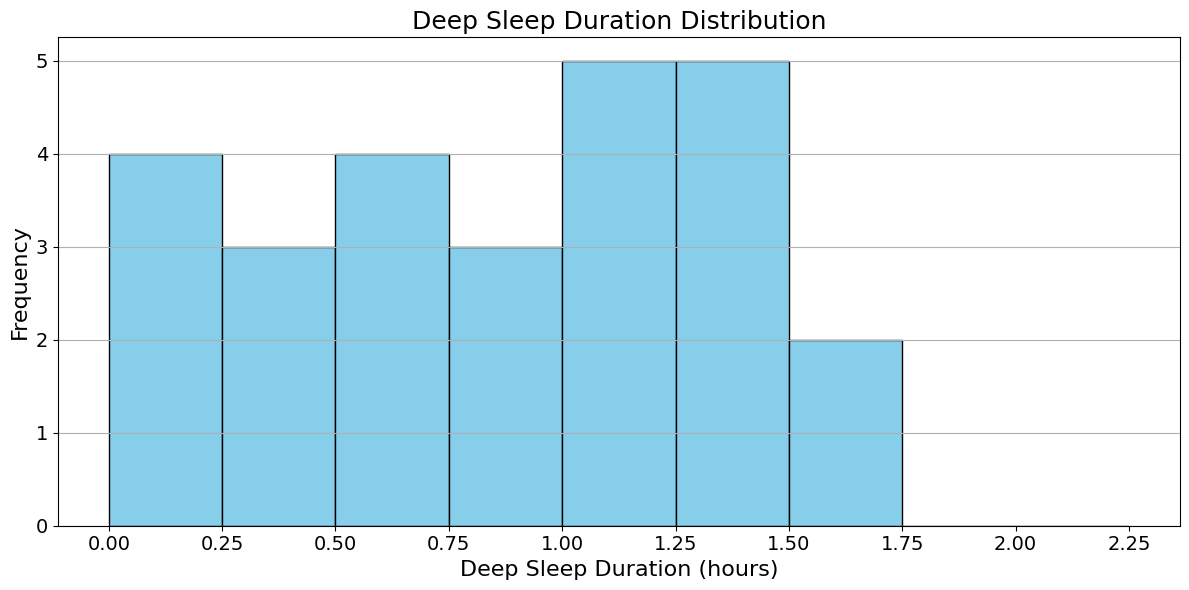

In [19]:
# define bins
bins = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
bins = u.generate_bins(np.floor(min(deep_sleep_counts)), np.ceil(max(deep_sleep_counts)), 0.25)
# plot
plt.figure(figsize=(12, 6))
plt.hist(deep_sleep_counts, bins=bins, edgecolor="k", color='skyblue')
plt.title('Deep Sleep Duration Distribution', fontsize=18)
plt.xlabel('Deep Sleep Duration (hours)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(bins, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

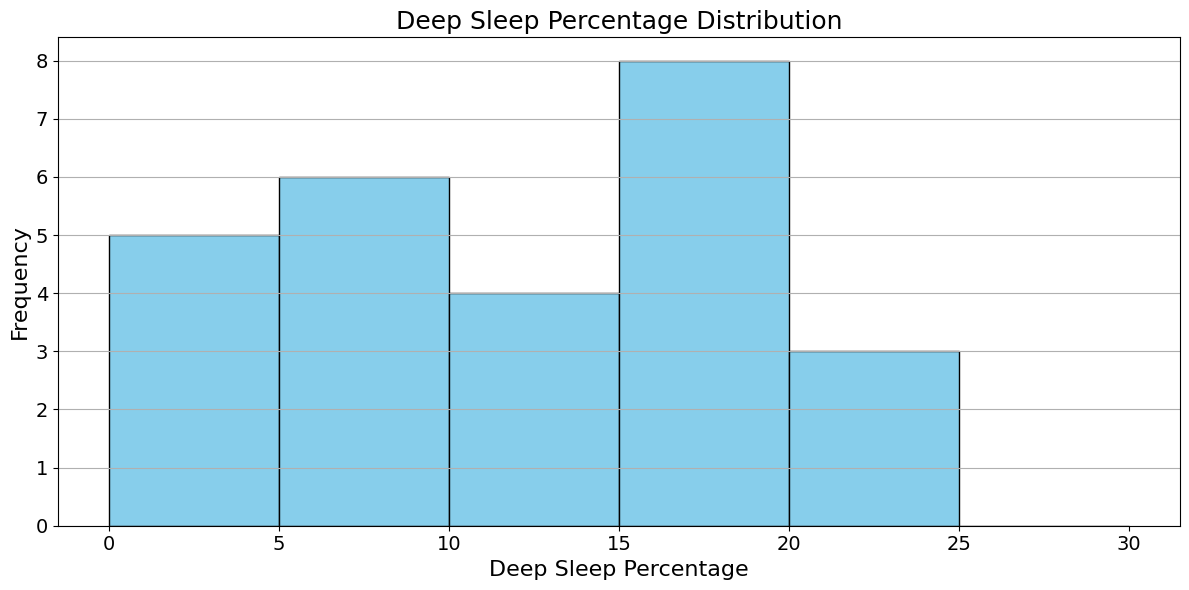

In [20]:
# define bins
bins = [0, 10, 20, 30, 40, 50]
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

bins = u.generate_bins(np.floor(min(deep_percentages)), np.ceil(max(deep_percentages)), 5)

# plot
plt.figure(figsize=(12, 6))
plt.hist(deep_percentages, bins=bins, edgecolor="k", color='skyblue')
plt.title('Deep Sleep Percentage Distribution', fontsize=18)
plt.xlabel('Deep Sleep Percentage', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(bins, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

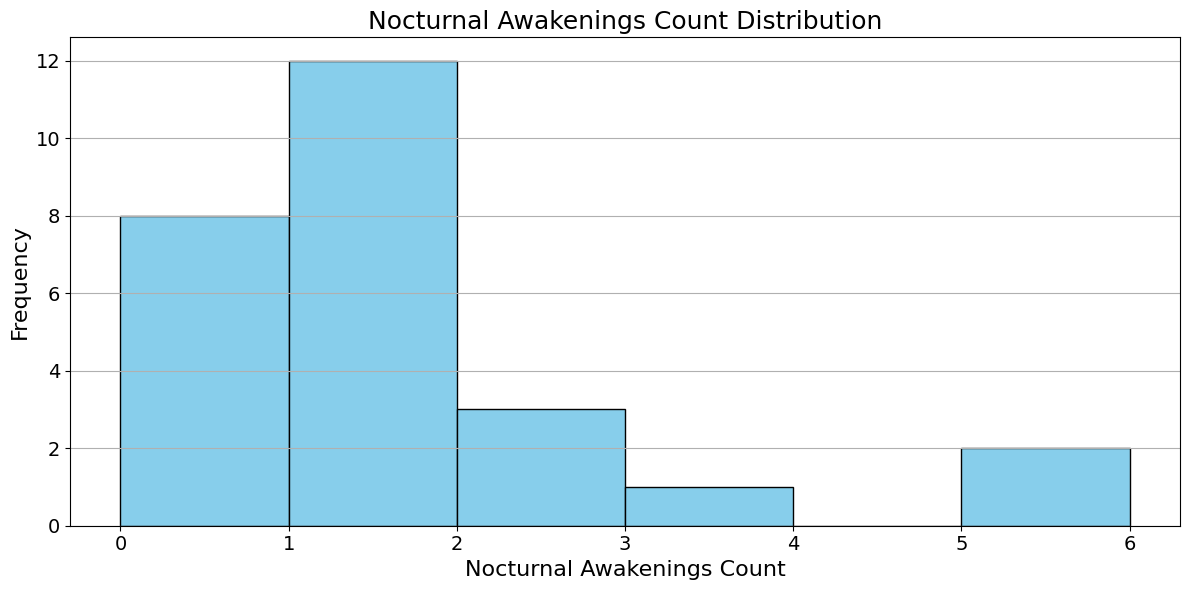

In [22]:
# define bins
# bins = [0, 10, 20, 30, 40, 50]
bins = [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40]

bins = u.generate_bins(np.floor(min(wake_up_counts)), np.ceil(max(wake_up_counts)), 1)

# plot
plt.figure(figsize=(12, 6))
plt.hist(wake_up_counts, bins=bins, edgecolor="k", color='skyblue')
plt.title('Nocturnal Awakenings Count Distribution', fontsize=18)
plt.xlabel('Nocturnal Awakenings Count', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(bins, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [23]:
# conduct the Shapiro-Wilk test
print('Steps counts:')
shapiro(steps_counts)

Steps counts:


ShapiroResult(statistic=0.884569525718689, pvalue=0.007199469022452831)

In [24]:
# conduct the Shapiro-Wilk test
print('Sleep duration:')
shapiro(sleep_counts)

Sleep duration:


ShapiroResult(statistic=0.9174191355705261, pvalue=0.03913095220923424)

In [25]:
# conduct the Shapiro-Wilk test
print('Deep sleep duration:')
shapiro(deep_sleep_counts)

Deep sleep duration:


ShapiroResult(statistic=0.951141893863678, pvalue=0.24658739566802979)

In [26]:
# conduct the Shapiro-Wilk test
print('Deep sleep percentage:')
shapiro(deep_percentages)

Deep sleep percentage:


ShapiroResult(statistic=0.9629603028297424, pvalue=0.45313161611557007)

In [27]:
# conduct the Shapiro-Wilk test
print('Wake-ups count:')
shapiro(wake_up_counts)

Wake-ups count:


ShapiroResult(statistic=0.7411479353904724, pvalue=2.0466693968046457e-05)

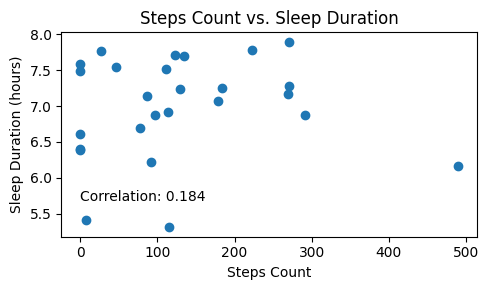

In [28]:
# Create the first plot
fig1, ax1 = plt.subplots(figsize=(5, 3))
ax1.scatter(steps_counts, sleep_counts)
ax1.set_xlabel('Steps Count')
ax1.set_ylabel('Sleep Duration (hours)')
ax1.set_title('Steps Count vs. Sleep Duration')
corr, _ = spearmanr(steps_counts, sleep_counts)
ax1.text(0, min(sleep_counts)*1.07, f'Correlation: {corr:.3f}')

plt.tight_layout()
plt.show()

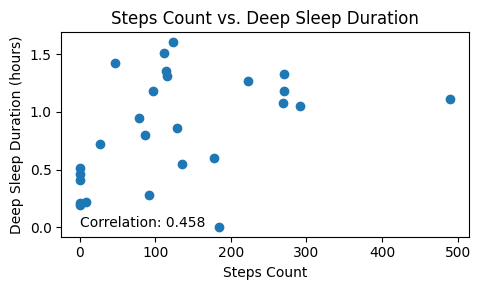

In [29]:
# Create the second plot
fig2, ax2 = plt.subplots(figsize=(5, 3))
ax2.scatter(steps_counts, deep_sleep_counts)
ax2.set_xlabel('Steps Count')
ax2.set_ylabel('Deep Sleep Duration (hours)')
ax2.set_title('Steps Count vs. Deep Sleep Duration')
corr, _ = spearmanr(steps_counts, deep_sleep_counts)
ax2.text(0, min(deep_sleep_counts), f'Correlation: {corr:.3f}')

# Show the plots in a column
plt.tight_layout()
plt.show()

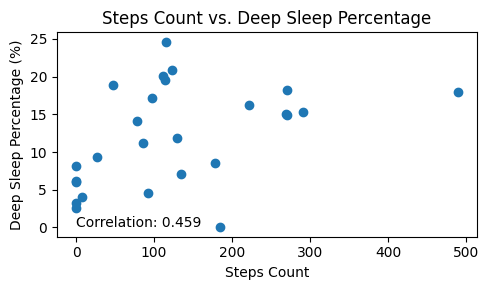

In [30]:
# Create the third plot
fig3, ax3 = plt.subplots(figsize=(5, 3))
ax3.scatter(steps_counts, deep_percentages)
ax3.set_xlabel('Steps Count')
ax3.set_ylabel('Deep Sleep Percentage (%)')
ax3.set_title('Steps Count vs. Deep Sleep Percentage')
corr, _ = spearmanr(steps_counts, deep_percentages)
ax3.text(0, 0, f'Correlation: {corr:.3f}')

# Show the plots in a column
plt.tight_layout()
plt.show()

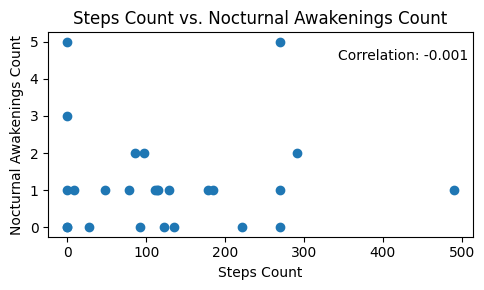

In [31]:
# Create the fourth plot
fig4, ax4 = plt.subplots(figsize=(5, 3))
ax4.scatter(steps_counts, wake_up_counts)
ax4.set_xlabel('Steps Count')
ax4.set_ylabel('Nocturnal Awakenings Count')
ax4.set_title('Steps Count vs. Nocturnal Awakenings Count')
corr, _ = spearmanr(steps_counts, wake_up_counts)
ax4.text(max(steps_counts)*0.7, max(wake_up_counts)*0.9, f'Correlation: {corr:.3f}')

# Show the plots in a column
plt.tight_layout()
plt.show()

## Steps aggregated from the previous day

In [32]:
steps_counts = []
sleep_counts = []
deep_sleep_counts = []
deep_percentages = []
wake_up_counts = []

for subject in subjects_as_ints:
    steps_subset = steps[steps['id'] == str(subject)]
    steps_count = p.steps_count(steps_subset, -18)

    sleep_subset = sleep_df[sleep_df['id'] == str(subject)]
    sleep_count = p.measure_sleep(sleep_subset)
    sleep_count = sleep_count * 30 / 3600
    if sleep_count > 4 and steps_count > 0:
        steps_counts.append(steps_count)
        sleep_counts.append(sleep_count)

        deep_sleep_count = p.measure_deep_sleep(sleep_subset)
        deep_sleep_count = deep_sleep_count * 30 / 3600
        deep_sleep_counts.append(deep_sleep_count)

        deep_percentage = (deep_sleep_count / sleep_count * 100) if sleep_count != 0 else 0
        deep_percentages.append(deep_percentage)

        wake_up_count = p.count_awakenings(sleep_subset)
        wake_up_counts.append(wake_up_count)
    else:
        print(subject)

3509524
5132496
1066528
4018081
8258170
759667
46343


In [33]:
# conduct the Shapiro-Wilk test
print('Steps counts:')
shapiro(steps_counts)

Steps counts:


ShapiroResult(statistic=0.9487619996070862, pvalue=0.2546848952770233)

In [34]:
# conduct the Shapiro-Wilk test
print('Sleep duration:')
shapiro(sleep_counts)

Sleep duration:


ShapiroResult(statistic=0.89006507396698, pvalue=0.013332642614841461)

In [35]:
# conduct the Shapiro-Wilk test
print('Deep sleep duration:')
shapiro(deep_sleep_counts)

Deep sleep duration:


ShapiroResult(statistic=0.9431267976760864, pvalue=0.19144801795482635)

In [36]:
# conduct the Shapiro-Wilk test
print('Deep sleep percentage:')
shapiro(deep_percentages)

Deep sleep percentage:


ShapiroResult(statistic=0.9576311111450195, pvalue=0.39270293712615967)

In [37]:
# conduct the Shapiro-Wilk test
print('Wake-ups count:')
shapiro(wake_up_counts)

Wake-ups count:


ShapiroResult(statistic=0.756958544254303, pvalue=6.30420763627626e-05)

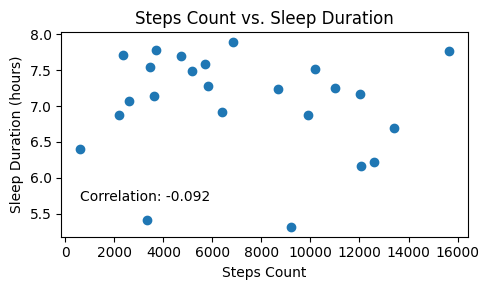

In [38]:
# Create the first plot
fig1, ax1 = plt.subplots(figsize=(5, 3))
ax1.scatter(steps_counts, sleep_counts)
ax1.set_xlabel('Steps Count')
ax1.set_ylabel('Sleep Duration (hours)')
ax1.set_title('Steps Count vs. Sleep Duration')
corr, _ = spearmanr(steps_counts, sleep_counts)
ax1.text(min(steps_counts), min(sleep_counts)*1.07, f'Correlation: {corr:.3f}')

plt.tight_layout()
plt.show()

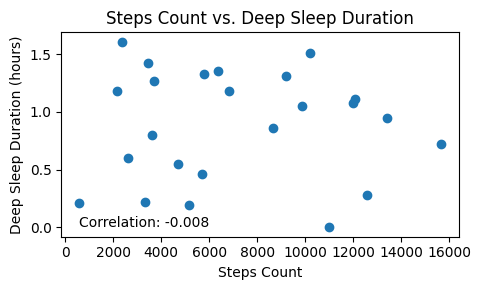

In [39]:
# Create the second plot
fig2, ax2 = plt.subplots(figsize=(5, 3))
ax2.scatter(steps_counts, deep_sleep_counts)
ax2.set_xlabel('Steps Count')
ax2.set_ylabel('Deep Sleep Duration (hours)')
ax2.set_title('Steps Count vs. Deep Sleep Duration')
corr, _ = pearsonr(steps_counts, deep_sleep_counts)
ax2.text(min(steps_counts), min(deep_sleep_counts), f'Correlation: {corr:.3f}')

# Show the plots in a column
plt.tight_layout()
plt.show()

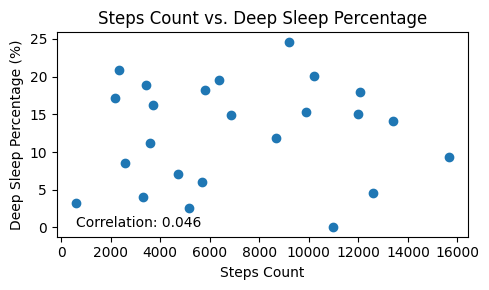

In [40]:
# Create the third plot
fig3, ax3 = plt.subplots(figsize=(5, 3))
ax3.scatter(steps_counts, deep_percentages)
ax3.set_xlabel('Steps Count')
ax3.set_ylabel('Deep Sleep Percentage (%)')
ax3.set_title('Steps Count vs. Deep Sleep Percentage')
corr, _ = pearsonr(steps_counts, deep_percentages)
ax3.text(min(steps_counts), 0, f'Correlation: {corr:.3f}')

# Show the plots in a column
plt.tight_layout()
plt.show()

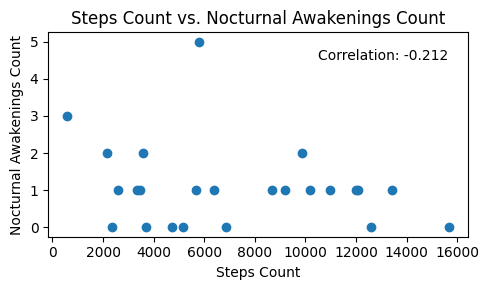

In [41]:
# Create the fourth plot
fig4, ax4 = plt.subplots(figsize=(5, 3))
ax4.scatter(steps_counts, wake_up_counts)
ax4.set_xlabel('Steps Count')
ax4.set_ylabel('Nocturnal Awakenings Count')
ax4.set_title('Steps Count vs. Nocturnal Awakenings Count')
corr, _ = spearmanr(steps_counts, wake_up_counts)
ax4.text(max(steps_counts)*0.67, max(wake_up_counts)*0.9, f'Correlation: {corr:.3f}')

# Show the plots in a column
plt.tight_layout()
plt.show()

## Steps aggregated from the whole period

In [42]:
invalid_subjects = [3509524,
                    5132496,
                    1066528,
                    4018081,
                    8258170,
                    759667,
                    46343]

In [43]:
steps_counts = []
sleep_counts = []
deep_sleep_counts = []
deep_percentages = []
wake_up_counts = []

for subject in subjects_as_ints:
    steps_subset = steps[steps['id'] == str(subject)]
    steps_count = p.steps_count(steps_subset, -74)

    sleep_subset = sleep_df[sleep_df['id'] == str(subject)]
    sleep_count = p.measure_sleep(sleep_subset)
    sleep_count = sleep_count * 30 / 3600

    if sleep_count > 4 and subject not in invalid_subjects:
        if steps_count < 10000:
            print('<10000 ', subject)
        steps_counts.append(steps_count)
        sleep_counts.append(sleep_count)

        deep_sleep_count = p.measure_deep_sleep(sleep_subset)
        deep_sleep_count = deep_sleep_count * 30 / 3600
        deep_sleep_counts.append(deep_sleep_count)

        deep_percentage = (deep_sleep_count / sleep_count * 100) if sleep_count != 0 else 0
        deep_percentages.append(deep_percentage)

        wake_up_count = p.count_awakenings(sleep_subset)
        wake_up_counts.append(wake_up_count)
    else:
        print(subject)

3509524
5132496
1066528
4018081
8258170
<10000  8173033
759667
46343


In [44]:
# conduct the Shapiro-Wilk test
print('Steps counts:')
shapiro(steps_counts)

Steps counts:


ShapiroResult(statistic=0.9140347242355347, pvalue=0.04318103566765785)

In [45]:
# conduct the Shapiro-Wilk test
print('Sleep duration:')
shapiro(sleep_counts)

Sleep duration:


ShapiroResult(statistic=0.89006507396698, pvalue=0.013332642614841461)

In [46]:
# conduct the Shapiro-Wilk test
print('Deep sleep duration:')
shapiro(deep_sleep_counts)

Deep sleep duration:


ShapiroResult(statistic=0.9431267976760864, pvalue=0.19144801795482635)

In [47]:
# conduct the Shapiro-Wilk test
print('Deep sleep percentage:')
shapiro(deep_percentages)

Deep sleep percentage:


ShapiroResult(statistic=0.9576311111450195, pvalue=0.39270293712615967)

In [48]:
# conduct the Shapiro-Wilk test
print('Wake-ups count:')
shapiro(wake_up_counts)

Wake-ups count:


ShapiroResult(statistic=0.756958544254303, pvalue=6.30420763627626e-05)

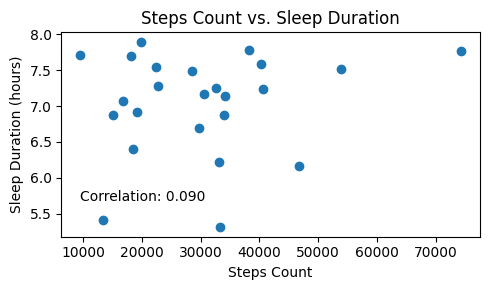

In [49]:
# Create the first plot
fig1, ax1 = plt.subplots(figsize=(5, 3))
ax1.scatter(steps_counts, sleep_counts)
ax1.set_xlabel('Steps Count')
ax1.set_ylabel('Sleep Duration (hours)')
ax1.set_title('Steps Count vs. Sleep Duration')
corr, _ = spearmanr(steps_counts, sleep_counts)
ax1.text(min(steps_counts), min(sleep_counts)*1.07, f'Correlation: {corr:.3f}')

plt.tight_layout()
plt.show()

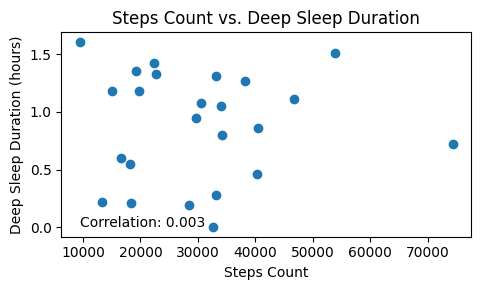

In [50]:
# Create the second plot
fig2, ax2 = plt.subplots(figsize=(5, 3))
ax2.scatter(steps_counts, deep_sleep_counts)
ax2.set_xlabel('Steps Count')
ax2.set_ylabel('Deep Sleep Duration (hours)')
ax2.set_title('Steps Count vs. Deep Sleep Duration')
corr, _ = spearmanr(steps_counts, deep_sleep_counts)
ax2.text(min(steps_counts), min(deep_sleep_counts), f'Correlation: {corr:.3f}')

# Show the plots in a column
plt.tight_layout()
plt.show()

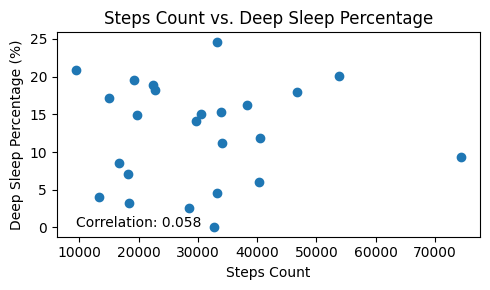

In [51]:
# Create the third plot
fig3, ax3 = plt.subplots(figsize=(5, 3))
ax3.scatter(steps_counts, deep_percentages)
ax3.set_xlabel('Steps Count')
ax3.set_ylabel('Deep Sleep Percentage (%)')
ax3.set_title('Steps Count vs. Deep Sleep Percentage')
corr, _ = spearmanr(steps_counts, deep_percentages)
ax3.text(min(steps_counts), 0, f'Correlation: {corr:.3f}')

# Show the plots in a column
plt.tight_layout()
plt.show()

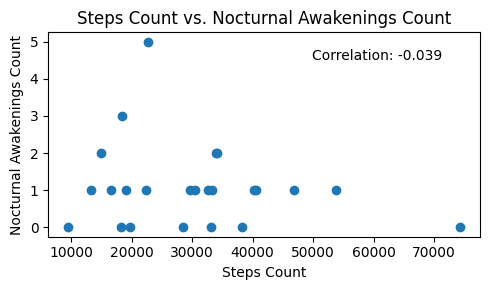

In [52]:
# Create the fourth plot
fig4, ax4 = plt.subplots(figsize=(5, 3))
ax4.scatter(steps_counts, wake_up_counts)
ax4.set_xlabel('Steps Count')
ax4.set_ylabel('Nocturnal Awakenings Count')
ax4.set_title('Steps Count vs. Nocturnal Awakenings Count')
corr, _ = spearmanr(steps_counts, wake_up_counts)
ax4.text(max(steps_counts)*0.67, max(wake_up_counts)*0.9, f'Correlation: {corr:.3f}')

# Show the plots in a column
plt.tight_layout()
plt.show()

## Plot steps distribution

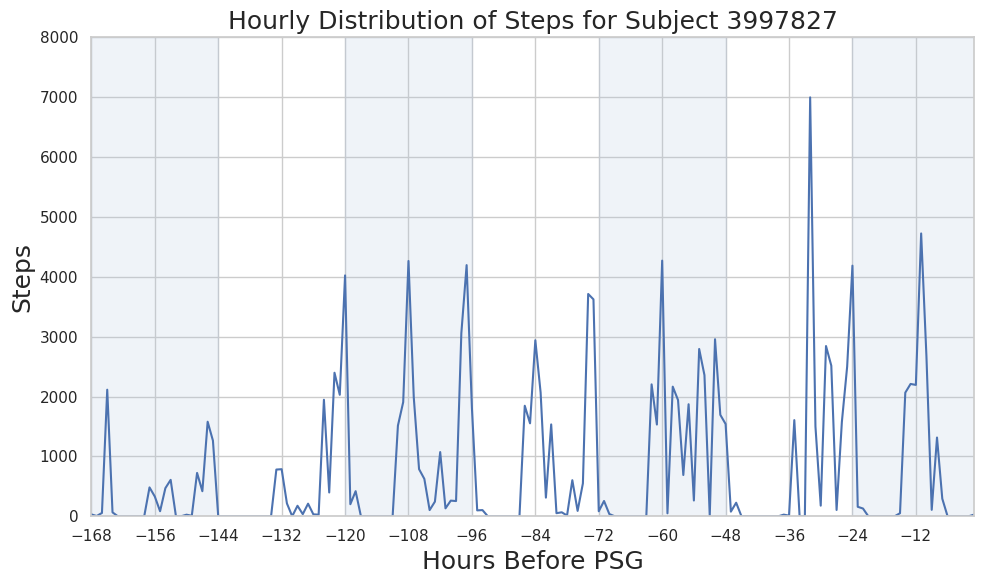

In [53]:
sns.set(style="whitegrid")

# Create a figure and a set of subplots
plt.figure(figsize=(10, 6))

x_min, x_max = steps['hour_bin'].min(), steps['hour_bin'].max()
y_max = steps['steps'].max()

hour_bins = range(int(x_min), int(x_max), 48)

# Add vertical spans for each 24-hour period
for start in hour_bins:
    plt.axvspan(start, start + 24, color='lightsteelblue', alpha=0.2)

subject = 3997827
subset = steps[steps['id'] == str(3997827)]
plt.plot(subset['hour_bin'], subset['steps'])

y_max = 8000
plt.xlim(x_min, x_max)
plt.ylim(0, y_max)

plt.xticks(range(int(x_min), int(x_max) + 1, 12))

# Adding labels and title
plt.xlabel('Hours Before PSG', fontsize=18)
plt.ylabel('Steps', fontsize=18)
plt.title(f'Hourly Distribution of Steps for Subject {subject}', fontsize=18)

plt.tight_layout()  # Adjust the layout
# Show the plot
plt.show()

In [54]:
steps_subset = steps[steps['id'] == str(3997827)]
steps_count = p.steps_count(steps_subset, -168)
print('Average steps per day: ', steps_count/7)

sleep_subset = sleep_df[sleep_df['id'] == str(3997827)]
sleep_count = p.measure_sleep(sleep_subset)
sleep_count = sleep_count * 30 / 3600
print('Hours of sleep: ', sleep_count)

deep_sleep_count = p.measure_deep_sleep(sleep_subset)
deep_sleep_count = deep_sleep_count * 30 / 3600
print('Hours of deep sleep: ', deep_sleep_count)

deep_percentage = (deep_sleep_count / sleep_count * 100) if sleep_count != 0 else 0
print('Percentage of deep sleep: ', deep_percentage)

wake_up_count = p.count_awakenings(sleep_subset)
print('Arousals at night: ', wake_up_count)

Average steps per day:  18614.14285714286
Hours of sleep:  7.775
Hours of deep sleep:  0.725
Percentage of deep sleep:  9.32475884244373
Arousals at night:  0


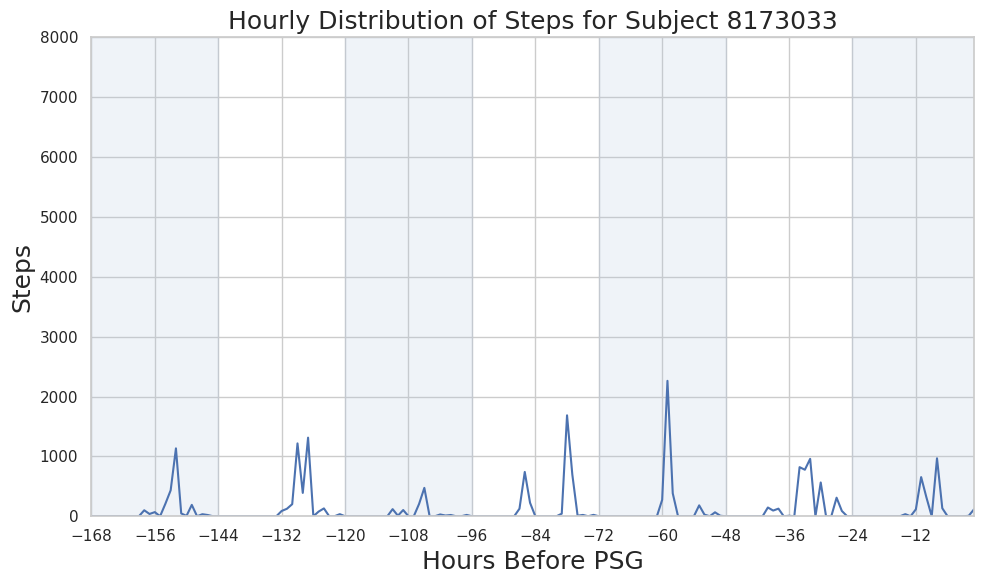

In [55]:
sns.set(style="whitegrid")

# Create a figure and a set of subplots
plt.figure(figsize=(10, 6))

x_min, x_max = steps['hour_bin'].min(), steps['hour_bin'].max()
y_max = steps['steps'].max()

hour_bins = range(int(x_min), int(x_max), 48)

# Add vertical spans for each 24-hour period
for start in hour_bins:
    plt.axvspan(start, start + 24, color='lightsteelblue', alpha=0.2)

subject = 8173033
subset = steps[steps['id'] == str(8173033)]
plt.plot(subset['hour_bin'], subset['steps'])

y_max = 8000
plt.xlim(x_min, x_max)
plt.ylim(0, y_max)

plt.xticks(range(int(x_min), int(x_max) + 1, 12))

# Adding labels and title
plt.xlabel('Hours Before PSG', fontsize=18)
plt.ylabel('Steps', fontsize=18)
plt.title(f'Hourly Distribution of Steps for Subject {subject}', fontsize=18)

plt.tight_layout()  # Adjust the layout
# Show the plot
plt.show()

In [ ]:
steps_subset = steps[steps['id'] == str(8173033)]
steps_count = p.steps_count(steps_subset, -168)
print('Average steps per day: ', steps_count/7)

sleep_subset = sleep_df[sleep_df['id'] == str(8173033)]
sleep_count = p.measure_sleep(sleep_subset)
sleep_count = sleep_count * 30 / 3600
print('Hours of sleep: ', sleep_count)

deep_sleep_count = p.measure_deep_sleep(sleep_subset)
deep_sleep_count = deep_sleep_count * 30 / 3600
print('Hours of deep sleep: ', deep_sleep_count)

deep_percentage = (deep_sleep_count / sleep_count * 100) if sleep_count != 0 else 0
print('Percentage of deep sleep: ', deep_percentage)

wake_up_count = p.count_awakenings(sleep_subset)
print('Arousals at night: ', wake_up_count)

Average steps per day:  2838.285714285714
Hours of sleep:  7.716666666666667
Hours of deep sleep:  1.6083333333333334
Percentage of deep sleep:  20.84233261339093
Arousals at night:  0


In [56]:
df.shape

(25141, 14)

In [57]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [58]:
X = df[['heartrate', 'heartrate_std', 'x_mean', 'x_std', 'y_mean', 'y_std', 'z_mean', 'z_std', 'magnitude', 'magnitude_std']]  # Replace with your features
y = df['wake'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=13)


In [59]:
# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

# Initialize the model
model = RandomForestClassifier(random_state=13, n_estimators=100, max_depth=6)

# Store the accuracy for each fold
accuracies = []

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y), start=1):
    # Split data
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE for each fold
    smote = SMOTE(random_state=13)
    X_train_fold_oversampled, y_train_fold_oversampled = smote.fit_resample(X_train_fold, y_train_fold)

    # Scale features
    scaler = StandardScaler()
    X_train_fold_scaled = scaler.fit_transform(X_train_fold_oversampled)
    X_test_fold_scaled = scaler.transform(X_test_fold)

    # Train the model on the oversampled and scaled training data
    model.fit(X_train_fold_scaled, y_train_fold_oversampled)

    # Make predictions and evaluate on the original (non-oversampled) test data
    y_pred_fold = model.predict(X_test_fold_scaled)
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    accuracies.append(accuracy)

    # Print detailed classification report
    print(f'Fold {fold} Classification Report:')
    print(classification_report(y_test_fold, y_pred_fold))

average_cv_score = sum(accuracies) / len(accuracies)
print("Average Cross-Validation Accuracy:", average_cv_score)


Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      4595
           1       0.37      0.59      0.46       434

    accuracy                           0.88      5029
   macro avg       0.66      0.75      0.69      5029
weighted avg       0.91      0.88      0.89      5029

Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      4595
           1       0.38      0.58      0.46       433

    accuracy                           0.88      5028
   macro avg       0.67      0.75      0.70      5028
weighted avg       0.91      0.88      0.89      5028

Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      4595
           1       0.43      0.56      0.48       433

    accuracy                           0.90      5028
   macro avg       0.69      0.74     

In [60]:
smote = SMOTE(random_state=13)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_oversampled)

final_model = RandomForestClassifier(random_state=13, n_estimators=100, max_depth=6)
final_model.fit(X_train_scaled, y_train_oversampled)

RandomForestClassifier(max_depth=6, random_state=13)

In [61]:
X_test_scaled = scaler.transform(X_test)
y_pred_test = final_model.predict(X_test_scaled)
print("Random Forest Final Model Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Random Forest Final Model Classification Report on Test Data:")
print(classification_report(y_test, y_pred_test))

Random Forest Final Model Test Accuracy: 0.8910320143169617
Random Forest Final Model Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      4596
           1       0.40      0.54      0.46       433

    accuracy                           0.89      5029
   macro avg       0.68      0.73      0.70      5029
weighted avg       0.91      0.89      0.90      5029



In [62]:
X_train_scaled = scaler.transform(X_train)
y_pred_train = final_model.predict(X_train_scaled)
print("Random Forest Final Model Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Random Forest Final Model Classification Report on Test Data:")
print(classification_report(y_train, y_pred_train))

Random Forest Final Model Train Accuracy: 0.8922533810660302
Random Forest Final Model Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94     18379
           1       0.41      0.54      0.46      1733

    accuracy                           0.89     20112
   macro avg       0.68      0.73      0.70     20112
weighted avg       0.91      0.89      0.90     20112



In [63]:
# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

# Store the accuracy for each fold
accuracies = []

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X_train, y_train), start=1):
    # Split data
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Apply SMOTE for each fold
    smote = SMOTE(random_state=13)
    X_train_fold_oversampled, y_train_fold_oversampled = smote.fit_resample(X_train_fold, y_train_fold)

    # Scale features
    scaler = StandardScaler()
    X_train_fold_scaled = scaler.fit_transform(X_train_fold_oversampled)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=13, max_iter=1000)
    model.fit(X_train_fold_scaled, y_train_fold_oversampled)

    # Make predictions and evaluate on the validation data
    y_pred_fold = model.predict(X_val_fold_scaled)
    accuracy = accuracy_score(y_val_fold, y_pred_fold)
    accuracies.append(accuracy)

    # Print detailed classification report for each fold
    print(f'Fold {fold} Classification Report:')
    print(classification_report(y_val_fold, y_pred_fold))

average_cv_score = sum(accuracies) / len(accuracies)
print("Average Cross-Validation Accuracy:", average_cv_score)


Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3676
           1       0.39      0.44      0.41       347

    accuracy                           0.89      4023
   macro avg       0.67      0.69      0.68      4023
weighted avg       0.90      0.89      0.90      4023

Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      3676
           1       0.34      0.39      0.36       347

    accuracy                           0.88      4023
   macro avg       0.64      0.66      0.65      4023
weighted avg       0.89      0.88      0.88      4023

Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3676
           1       0.40      0.43      0.41       346

    accuracy                           0.89      4022
   macro avg       0.67      0.68     

In [64]:
smote = SMOTE(random_state=13)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_oversampled)

final_model = LogisticRegression(random_state=13, max_iter=1000)
final_model.fit(X_train_scaled, y_train_oversampled)

LogisticRegression(max_iter=1000, random_state=13)

In [65]:
X_test_scaled = scaler.transform(X_test)
y_pred_test = final_model.predict(X_test_scaled)
print("Logistic Regression Final Model Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Logistic Regression Final Model Classification Report on Test Data:")
print(classification_report(y_test, y_pred_test))

Logistic Regression Final Model Test Accuracy: 0.8965997216146351
Logistic Regression Final Model Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4596
           1       0.40      0.40      0.40       433

    accuracy                           0.90      5029
   macro avg       0.67      0.67      0.67      5029
weighted avg       0.90      0.90      0.90      5029



In [66]:
X_train_scaled = scaler.transform(X_train)
y_pred_train = final_model.predict(X_train_scaled)
print("Logistic Regression Final Model Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Logistic Regression Final Model Classification Report on Test Data:")
print(classification_report(y_train, y_pred_train))

Logistic Regression Final Model Train Accuracy: 0.8938941925218775
Logistic Regression Final Model Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     18379
           1       0.39      0.43      0.41      1733

    accuracy                           0.89     20112
   macro avg       0.67      0.68      0.68     20112
weighted avg       0.90      0.89      0.90     20112



In [90]:
# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

# Store the accuracy for each fold
accuracies = []

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X_train, y_train), start=1):
    # Split data
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Apply SMOTE for each fold
    smote = SMOTE(random_state=13)
    X_train_fold_oversampled, y_train_fold_oversampled = smote.fit_resample(X_train_fold, y_train_fold)

    # Scale features
    scaler = StandardScaler()
    X_train_fold_scaled = scaler.fit_transform(X_train_fold_oversampled)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Initialize and train the Neural Network (MLPClassifier)
    model = MLPClassifier(hidden_layer_sizes=(50,25), max_iter=1000, random_state=13,
                      early_stopping=True,
                      n_iter_no_change=20,
                      alpha=0.001)
    model.fit(X_train_fold_scaled, y_train_fold_oversampled)

    # Make predictions and evaluate on the validation data
    y_pred_fold = model.predict(X_val_fold_scaled)
    accuracy = accuracy_score(y_val_fold, y_pred_fold)
    accuracies.append(accuracy)

    # Print detailed classification report for each fold
    print(f'Fold {fold} Classification Report:')
    print(classification_report(y_val_fold, y_pred_fold))

average_cv_score = sum(accuracies) / len(accuracies)
print("Average Cross-Validation Accuracy:", average_cv_score)


Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      3676
           1       0.43      0.68      0.52       347

    accuracy                           0.89      4023
   macro avg       0.70      0.80      0.73      4023
weighted avg       0.92      0.89      0.90      4023

Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      3676
           1       0.43      0.67      0.53       347

    accuracy                           0.90      4023
   macro avg       0.70      0.79      0.73      4023
weighted avg       0.92      0.90      0.91      4023

Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3676
           1       0.48      0.63      0.55       346

    accuracy                           0.91      4022
   macro avg       0.72      0.78     

In [87]:
smote = SMOTE(random_state=13)
X_oversampled, y_oversampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_oversampled)

model = MLPClassifier(hidden_layer_sizes=(50,25), max_iter=1000, random_state=13,
                      early_stopping=True,
                      n_iter_no_change=20,
                      alpha=0.001)
model.fit(X_scaled, y_oversampled)

MLPClassifier(alpha=0.001, early_stopping=True, hidden_layer_sizes=(50, 25),
              max_iter=1000, n_iter_no_change=20, random_state=13)

In [88]:
X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Neural Network Final Model Test Accuracy:", accuracy)

print("Neural Network Final Model Classification Report on Test Data:")
print(classification_report(y_test, y_pred))

Neural Network Final Model Test Accuracy: 0.8916285543845694
Neural Network Final Model Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      4596
           1       0.42      0.72      0.53       433

    accuracy                           0.89      5029
   macro avg       0.70      0.81      0.74      5029
weighted avg       0.92      0.89      0.90      5029



In [89]:
X_scaled = scaler.transform(X_train)

y_pred = model.predict(X_scaled)

accuracy = accuracy_score(y_train, y_pred)
print("Neural Network Final Model Train Accuracy:", accuracy)

print("Neural Network Final Model Classification Report on Train Data:")
print(classification_report(y_train, y_pred))

Neural Network Final Model Train Accuracy: 0.9124403341288783
Neural Network Final Model Classification Report on Train Data:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     18379
           1       0.50      0.84      0.62      1733

    accuracy                           0.91     20112
   macro avg       0.74      0.88      0.79     20112
weighted avg       0.94      0.91      0.92     20112



## Deep sleep classification

In [91]:
def apply_deep_label(df):
    if df['label'] == 0:
        return 0
    elif df['label'] == 3:
        return 3
    else:
        return 1

df['deep'] = df.apply(apply_deep_label, axis=1)

In [92]:
X = df[['heartrate', 'heartrate_std', 'x_mean', 'x_std', 'y_mean', 'y_std', 'z_mean', 'z_std', 'magnitude', 'magnitude_std']]  # Replace with your features
y = df['deep'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=13)


In [93]:
# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

# Initialize the model
model = RandomForestClassifier(random_state=13, n_estimators=100, max_depth=6)

# Store the accuracy for each fold
accuracies = []

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y), start=1):
    # Split data
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE for each fold
    smote = SMOTE(random_state=13)
    X_train_fold_oversampled, y_train_fold_oversampled = smote.fit_resample(X_train_fold, y_train_fold)

    # Scale features
    scaler = StandardScaler()
    X_train_fold_scaled = scaler.fit_transform(X_train_fold_oversampled)
    X_test_fold_scaled = scaler.transform(X_test_fold)

    # Train the model on the oversampled and scaled training data
    model.fit(X_train_fold_scaled, y_train_fold_oversampled)

    # Make predictions and evaluate on the original (non-oversampled) test data
    y_pred_fold = model.predict(X_test_fold_scaled)
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    accuracies.append(accuracy)

    # Print detailed classification report
    print(f'Fold {fold} Classification Report:')
    print(classification_report(y_test_fold, y_pred_fold))

average_cv_score = sum(accuracies) / len(accuracies)
print("Average Cross-Validation Accuracy:", average_cv_score)


Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.51      0.45       434
           1       0.91      0.60      0.72      3957
           3       0.27      0.80      0.41       638

    accuracy                           0.62      5029
   macro avg       0.53      0.64      0.53      5029
weighted avg       0.78      0.62      0.66      5029

Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.52      0.45       433
           1       0.90      0.60      0.72      3958
           3       0.28      0.79      0.41       637

    accuracy                           0.62      5028
   macro avg       0.52      0.64      0.53      5028
weighted avg       0.78      0.62      0.66      5028

Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.53      0.45       433
           1       0.91      0.59      

In [94]:
smote = SMOTE(random_state=13)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_oversampled)

final_model = RandomForestClassifier(random_state=13, n_estimators=100, max_depth=6)
final_model.fit(X_train_scaled, y_train_oversampled)

RandomForestClassifier(max_depth=6, random_state=13)

In [95]:
X_test_scaled = scaler.transform(X_test)
y_pred_test = final_model.predict(X_test_scaled)
print("Random Forest Final Model Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Random Forest Final Model Classification Report on Test Data:")
print(classification_report(y_test, y_pred_test))

Random Forest Final Model Test Accuracy: 0.6217935971366076
Random Forest Final Model Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.37      0.47      0.41       433
           1       0.90      0.61      0.73      3958
           3       0.28      0.78      0.41       638

    accuracy                           0.62      5029
   macro avg       0.52      0.62      0.52      5029
weighted avg       0.78      0.62      0.66      5029



In [96]:
X_train_scaled = scaler.transform(X_train)
y_pred_train = final_model.predict(X_train_scaled)
print("Random Forest Final Model Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Random Forest Final Model Classification Report on Test Data:")
print(classification_report(y_train, y_pred_train))

Random Forest Final Model Train Accuracy: 0.6280827366746221
Random Forest Final Model Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.42      0.55      0.48      1733
           1       0.91      0.61      0.73     15828
           3       0.28      0.79      0.41      2551

    accuracy                           0.63     20112
   macro avg       0.54      0.65      0.54     20112
weighted avg       0.79      0.63      0.67     20112



In [97]:
# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

# Store the accuracy for each fold
accuracies = []

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X_train, y_train), start=1):
    # Split data
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Apply SMOTE for each fold
    smote = SMOTE(random_state=13)
    X_train_fold_oversampled, y_train_fold_oversampled = smote.fit_resample(X_train_fold, y_train_fold)

    # Scale features
    scaler = StandardScaler()
    X_train_fold_scaled = scaler.fit_transform(X_train_fold_oversampled)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=13, max_iter=1000)
    model.fit(X_train_fold_scaled, y_train_fold_oversampled)

    # Make predictions and evaluate on the validation data
    y_pred_fold = model.predict(X_val_fold_scaled)
    accuracy = accuracy_score(y_val_fold, y_pred_fold)
    accuracies.append(accuracy)

    # Print detailed classification report for each fold
    print(f'Fold {fold} Classification Report:')
    print(classification_report(y_val_fold, y_pred_fold))

average_cv_score = sum(accuracies) / len(accuracies)
print("Average Cross-Validation Accuracy:", average_cv_score)


Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.44      0.41       347
           1       0.88      0.56      0.68      3166
           3       0.23      0.74      0.35       510

    accuracy                           0.57      4023
   macro avg       0.50      0.58      0.48      4023
weighted avg       0.75      0.57      0.62      4023

Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.44      0.43       347
           1       0.87      0.57      0.69      3166
           3       0.21      0.67      0.32       510

    accuracy                           0.57      4023
   macro avg       0.50      0.56      0.48      4023
weighted avg       0.75      0.57      0.62      4023

Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.40      0.40       346
           1       0.87      0.56      

In [98]:
smote = SMOTE(random_state=13)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_oversampled)

final_model = LogisticRegression(random_state=13, max_iter=1000)
final_model.fit(X_train_scaled, y_train_oversampled)

LogisticRegression(max_iter=1000, random_state=13)

In [99]:
X_test_scaled = scaler.transform(X_test)
y_pred_test = final_model.predict(X_test_scaled)
print("Logistic Regression Final Model Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Logistic Regression Final Model Classification Report on Test Data:")
print(classification_report(y_test, y_pred_test))

Logistic Regression Final Model Test Accuracy: 0.5651222907138597
Logistic Regression Final Model Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.37      0.36      0.37       433
           1       0.86      0.57      0.69      3958
           3       0.22      0.67      0.33       638

    accuracy                           0.57      5029
   macro avg       0.48      0.54      0.46      5029
weighted avg       0.74      0.57      0.61      5029



In [100]:
X_train_scaled = scaler.transform(X_train)
y_pred_train = final_model.predict(X_train_scaled)
print("Logistic Regression Final Model Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Logistic Regression Final Model Classification Report on Test Data:")
print(classification_report(y_train, y_pred_train))

Logistic Regression Final Model Train Accuracy: 0.5704554494828958
Logistic Regression Final Model Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.40      0.42      0.41      1733
           1       0.87      0.57      0.69     15828
           3       0.22      0.70      0.34      2551

    accuracy                           0.57     20112
   macro avg       0.50      0.56      0.48     20112
weighted avg       0.75      0.57      0.62     20112



In [105]:
# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

# Store the accuracy for each fold
accuracies = []

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X_train, y_train), start=1):
    # Split data
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Apply SMOTE for each fold
    smote = SMOTE(random_state=13)
    X_train_fold_oversampled, y_train_fold_oversampled = smote.fit_resample(X_train_fold, y_train_fold)

    # Scale features
    scaler = StandardScaler()
    X_train_fold_scaled = scaler.fit_transform(X_train_fold_oversampled)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Initialize and train the Neural Network (MLPClassifier)
    model = MLPClassifier(hidden_layer_sizes=(50,25), max_iter=1000, random_state=13,
                      early_stopping=True,
                      n_iter_no_change=20,
                      alpha=0.001)
    model.fit(X_train_fold_scaled, y_train_fold_oversampled)

    # Make predictions and evaluate on the validation data
    y_pred_fold = model.predict(X_val_fold_scaled)
    accuracy = accuracy_score(y_val_fold, y_pred_fold)
    accuracies.append(accuracy)

    # Print detailed classification report for each fold
    print(f'Fold {fold} Classification Report:')
    print(classification_report(y_val_fold, y_pred_fold))

average_cv_score = sum(accuracies) / len(accuracies)
print("Average Cross-Validation Accuracy:", average_cv_score)


Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.64      0.51       347
           1       0.93      0.81      0.86      3166
           3       0.55      0.81      0.66       510

    accuracy                           0.79      4023
   macro avg       0.63      0.75      0.68      4023
weighted avg       0.84      0.79      0.81      4023

Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.64      0.52       347
           1       0.94      0.79      0.86      3166
           3       0.52      0.87      0.65       510

    accuracy                           0.78      4023
   macro avg       0.63      0.77      0.67      4023
weighted avg       0.84      0.78      0.80      4023

Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.60      0.48       346
           1       0.93      0.80      

In [106]:
smote = SMOTE(random_state=13)
X_oversampled, y_oversampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_oversampled)

model = MLPClassifier(hidden_layer_sizes=(50,25), max_iter=1000, random_state=13,
                      early_stopping=True,
                      n_iter_no_change=20,
                      alpha=0.001)
model.fit(X_scaled, y_oversampled)

MLPClassifier(alpha=0.001, early_stopping=True, hidden_layer_sizes=(50, 25),
              max_iter=1000, n_iter_no_change=20, random_state=13)

In [107]:
X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Neural Network Final Model Test Accuracy:", accuracy)

print("Neural Network Final Model Classification Report on Test Data:")
print(classification_report(y_test, y_pred))

Neural Network Final Model Test Accuracy: 0.8104991051898985
Neural Network Final Model Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.43      0.66      0.52       433
           1       0.93      0.82      0.88      3958
           3       0.60      0.83      0.70       638

    accuracy                           0.81      5029
   macro avg       0.66      0.77      0.70      5029
weighted avg       0.85      0.81      0.82      5029



In [108]:
X_scaled = scaler.transform(X_train)

y_pred = model.predict(X_scaled)

accuracy = accuracy_score(y_train, y_pred)
print("Neural Network Final Model Train Accuracy:", accuracy)

print("Neural Network Final Model Classification Report on Train Data:")
print(classification_report(y_train, y_pred))

Neural Network Final Model Train Accuracy: 0.8351233094669849
Neural Network Final Model Classification Report on Train Data:
              precision    recall  f1-score   support

           0       0.51      0.80      0.62      1733
           1       0.95      0.84      0.89     15828
           3       0.62      0.85      0.71      2551

    accuracy                           0.84     20112
   macro avg       0.69      0.83      0.74     20112
weighted avg       0.87      0.84      0.85     20112

